In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt

c:\Users\Aziz\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Ingestion**

In [2]:
# Read csv file
df = pd.read_csv('../data/cleaned_dataset.csv', sep=',')
df.sample(5)

,username,id,caption,Fashion and Style,Food and Dining,Family and Relationships,Sports and Fitness,Entertainment,Business and Industry,Travel and Adventure,Arts and Culture,News,Pets,Technology and Gadgets
12166,glossier,18214209733186027,cloud painting the movie with zoiamossour natu...,0,0,0,0,0,1,0,0,0,0,0
23250,apple,17977316257957166,when you pause on a moment like this you engra...,0,0,0,0,0,0,0,0,0,0,1
15984,lr_illustration,17981810602693186,full album cover for swissaustralian death met...,0,0,0,0,0,0,0,1,0,0,0
19758,elephantjournal,18347378638005629,before it happened to me a leaking bladder see...,0,0,0,1,0,0,0,0,0,1,0
10468,hotdudesreading,17852983948219521,is there anything better than reading a book s...,0,0,0,0,1,0,0,0,0,0,0


In [3]:
all_interests= [
    'Fashion and Style',
    'Food and Dining',
    'Family and Relationships',
    'Sports and Fitness',
    'Entertainment',
    'Business and Industry',
    'Travel and Adventure',
    'Arts and Culture',
    'News',
    'Pets',
    'Technology and Gadgets'
]

## **Preprocessing**

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [5]:
token = tokenizer.encode_plus(
    df['caption'].iloc[0], 
    max_length=256, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

In [6]:
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [7]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['caption']), total=len(df), desc='Generating training data', ncols=100):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [8]:
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

Generating training data: 100%|██████████████████████████████| 23749/23749 [00:32<00:00, 731.55it/s]


In [10]:
labels = df[all_interests].values.astype('int8')
labels.shape

(23749, 11)

In [11]:
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))

In [12]:
def dataset_map_function(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [13]:
dataset = dataset.map(dataset_map_function) # converting to required format for tensorflow dataset 

In [14]:
batch_size = 16
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True) # batch size, drop any left out tensor

In [15]:
p = 0.7 # 70% of data for training
train_size = int((len(df)//batch_size)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.
train_size

1038

In [16]:
# split the data into train and validation and test sets
train_dataset = dataset.take(train_size)
val_test_dataset = dataset.skip(train_size)
val_dataset = val_test_dataset.take(len(val_test_dataset)//2)
test_dataset = val_test_dataset.skip(len(val_test_dataset)//2)
# size of train, validation and test sets
len(train_dataset), len(val_dataset), len(test_dataset)

(1038, 223, 223)

## **Model & Training**

In [17]:
model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [18]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(labels.shape[1], activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

interest_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
interest_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [19]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=3e-5)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'), 
    tf.keras.metrics.Precision(name='precision'), # how many of the samples you predicted as positive are actually positive
    tf.keras.metrics.Recall(name='recall'), # how many of this class you find over the whole number of element of this class
]

interest_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [20]:
history = interest_model.fit(train_dataset, epochs=5, validation_data=val_dataset, verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/5
   7/1038 [..............................] - ETA: 5:13:53 - loss: 0.5821 - accuracy: 0.8393 - precision: 0.0000e+00 - recall: 0.0000e+00


KeyboardInterrupt



## **Evaluation**

In [21]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def prepare_data(input_text, tokenizer):
    input_text = clean_text(input_text)
    token = tokenizer.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=all_interests):
    probs = model.predict(processed_data)[0]
    threshold = 0.1
    # Return a pandas series of interests with probability greater than threshold
    return pd.Series(data=probs, index=classes)[lambda x: x > threshold].sort_values(ascending=False)

In [40]:
# Score the model on the test data and show random samples
test_loss, test_acc, test_prec, test_rec = interest_model.evaluate(test_dataset.take(10), verbose=1)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_acc}')

10/10 [==============================] - 74s 7s/step - loss: 0.0681 - accuracy: 0.9028 - precision: 0.9456 - recall: 0.4603
Test loss: 0.06806289404630661
Test accuracy: 0.9028409123420715


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming 'interest_model' is your trained BERT model

# Get predictions for the test data
y_true = []  # True labels
y_pred = []  # Predicted labels

for batch in test_dataset.take(10):
    # Extract input and target tensors
    inputs, targets = batch
    # Make predictions
    predictions = interest_model.predict(inputs)
    # Convert predictions to class labels
    predicted_labels = np.round(predictions)  # Round the predictions to get binary labels
    # Append true and predicted labels
    y_true.extend(targets.numpy().tolist())
    y_pred.extend(predicted_labels.tolist())

# Convert true and predicted labels to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate classification report
report = classification_report(y_true, y_pred, target_names=all_interests, zero_division=0, output_dict=True)

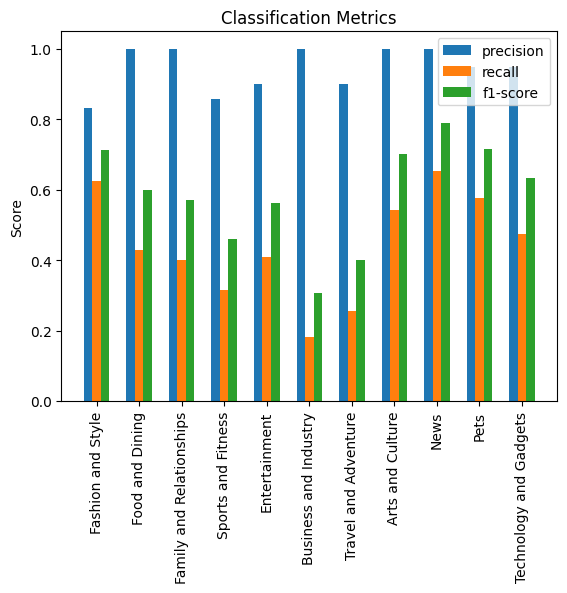

In [49]:
# Extract the metrics from the classification report
class_names = all_interests
metrics = ['precision', 'recall', 'f1-score']


# Plot the metrics
fig, ax = plt.subplots()
x = np.arange(len(class_names))
width = 0.2
for i, metric in enumerate(metrics):
    metric_values = [report[class_name][metric] for class_name in class_names]
    ax.bar(x + i * width, metric_values, width, label=metric)

# Set labels, title, and legend
ax.set_xticks(x + width)
ax.set_xticklabels(class_names, rotation=90)
ax.set_ylabel('Score')
ax.set_title('Classification Metrics')
ax.legend()

# Show the plot
plt.show()


In [39]:
print(report)

                          precision    recall  f1-score   support

       Fashion and Style       0.91      0.50      0.65        20
         Food and Dining       1.00      0.52      0.68        27
Family and Relationships       1.00      0.31      0.47        29
      Sports and Fitness       0.90      0.53      0.67        17
           Entertainment       0.95      0.47      0.63        38
   Business and Industry       1.00      0.29      0.45        34
    Travel and Adventure       0.90      0.17      0.29        52
        Arts and Culture       0.89      0.46      0.60        68
                    News       1.00      0.58      0.74        43
                    Pets       0.94      0.71      0.81        45
  Technology and Gadgets       0.85      0.61      0.71        64

               micro avg       0.92      0.47      0.62       437
               macro avg       0.94      0.47      0.61       437
            weighted avg       0.93      0.47      0.61       437
        

In [ ]:
# Save the model
interest_model.save('../artifacts/bert_interest_model_v2.h5')

## **Inference**

In [35]:
interest_model = tf.keras.models.load_model('../artifacts/bert_interest_model.h5')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [50]:
caption = 'We are looking for a Data Scientist with 3+ years of experience in Machine Learning and Deep Learning'
# caption = 'Cats are the best animals in the world'
# caption="Siraje ate my peanut butter and he eats pizza once a week."
processed_data = prepare_data(caption, tokenizer)
result = make_prediction(interest_model, processed_data=processed_data)
result

1/1 [==============================] - 1s 672ms/step


Technology and Gadgets    0.992274
dtype: float32